In [70]:
import cv2
import mediapipe as mp
from matplotlib import pyplot as plt
import numpy as np
from scipy import sparse
import math
import torch
import import_ipynb
import import_ipynb
import requests
from localAngle import calc_localAngle
from coordinate import coordinateFeature
from coordinate import normFunction
from distanceNode import distance_node_feature
from local_curvature import compute_curvature, compute_curvature_2, calc_local_curvature
from edge_orientation_feature import get_edge_orientation, get_edge_orientation_2, calc_edge_orientation
from exp import crop_and_rotate_image

In [71]:
def return_list_of_nodes():
    return([1, 10, 18, 33, 34, 48, 54, 58, 67, 133, 149, 151, 152, 195, 206, 263, 264, 278, 284, 288, 297, 362, 379, 426])
         # [0,  1,  2,  3,  4,  5,  6,  7,  8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23]
def return_list_of_edges():
    return([    [(0, 5),(0, 17), (0, 23), (0, 14)], 
                [(1, 8), (1, 6), (1, 18), (1, 20)], 
                [(2, 14), (2, 23), (2, 22), (2, 10)], 
                [(3, 4), (3, 6), (3, 9), (3, 14)], 
                [(4, 6), (4, 3), (4, 7)], 
                [(5, 14), (5, 9), (5, 13), (5, 0)],
                [(6, 8),(6, 1), (6, 11), (6, 3), (6, 4)], 
                [(7, 4), (7, 14), (7, 10)],
                [(8, 1),(8, 6)], 
                [(9, 3), (9, 11), (9, 13), (9, 5)], 
                [(10, 7), (10, 2), (10, 12)], 
                [(11, 6), (11, 18), (11, 21), (11, 9)],
                [(12, 10), (12, 22)], 
                [(13, 5), (13, 9), (13, 21), (13, 17)], 
                [(14, 0), (14, 2), (14, 7), (14, 3), (14, 5)], 
                [(15, 16), (15, 23), (15, 21), (15, 18)],
                [(16, 15), (16, 18), (16, 19)], 
                [(17, 0), (17, 13), (17, 21), (17, 23)], 
                [(18, 1), (18, 20), (18, 16), (18, 15), (18, 11)],
                [(19, 16), (19, 22), (19, 23)], 
                [(20, 1), (20, 18)], 
                [(21, 11), (21, 15), (21, 17), (21, 13)], 
                [(22, 2), (22, 19), (22, 12)],
                [(23, 0), (23, 17), (23, 15), (23, 19), (23, 2)]])
def return_number_of_angles():
    return([4,3,4,4,2,4,4,2,1,4,2,4,1, 4, 5, 4, 2, 4, 4, 2, 1, 4, 2, 5])
def return_list_of_angles():
    return([[(48, 1, 206),(48, 1, 278),(206, 1, 426),(278, 1, 426)],
            [(67, 10, 54),(54, 10, 284),(284, 10, 297)],
            [(206, 18, 149),(149, 18, 379),(179, 18, 426),(426, 18, 206)],
            [(34,33,54),(54,33,133),(133,33,206),(206,33,34)],
            [(54,34,33),(33,34,58)],
            [(1,48,195),(195,48,133),(133,48,206),(206,48,133)],
            [(33,54,34),(67,54,10),(10,54,151),(151,54,33)],
            [(34,58,206),(206,58,149)],
            [(54,67,10)],
            [(33,133,151),(151,133,195),(195,133,48),(48,133,33)],
            [(58,149,18),(18,149,152)],
            [(54,151,284),(284,151,362),(362,151,133),(133,151,54)],
            [(149,152,379)],
            [(48,195,133),(133,195,362),(362,195,278),(278,195,48)],
            [(1,206,48),(48,206,33),(33,206,58),(58,206,18),(18,206,1)],
            [(362,263,284),(284,263,264),(264,263,426),(426,263,362)],
            [(284,264,263),(263,264,288)],
            [(1,278,195),(195,278,362),(362,278,426),(426,278,1)],
            [(10, 284, 297),(10,284,151),(151,284,263),(263,284,264)],
            [(426,288,264),(426,288,379)],
            [(10,297,284)],
            [(151,362,195),(195,362,278),(278,362,263),(263,362,151)],
            [(18,379,288),(18,379,152)],
            [(1,426,278),(278,426,263),(263,426,288),(288,426,18),(18,426,1)]])


In [72]:
# def return_list_of_nodes():
#     return([0, 4, 6, 8, 12, 14, 17, 21, 22, 24, 33, 37, 39, 54, 58, 61, 67, 81, 84, 91, 94, 95, 102, 103, 109, 127, 132, 137, 150, 152, 158, 160, 172, 176, 178, 195, 227, 239, 243, 251, 252, 254, 258, 259, 263, 264, 267, 269, 271, 278, 284, 288, 291, 297, 314, 321, 323, 332, 338, 361, 362, 379, 397, 400, 402, 415, 447, 457])
#          # [0, 1, 2, 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67]
# def return_list_of_edges():
#     return([    [(0, 11),(0, 37), (0, 20), (0, 67), (0,46), (0, 4)], 
#                 [(1, 22), (1, 35), (1, 49), (1, 67), (1, 20),(1, 37)], 
#                 [(2, 38), (2, 3), (2, 60), (2, 35)], 
#                 [(3, 38), (3, 24), (3, 58), (3, 60), (3,2)], 
#                 [(4, 17), (4, 11), (4, 0), (4,46), (4, 48), (4, 5)], 
#                 [(5, 34), (5, 17), (5, 4), (5, 48), (5, 64), (5, 54), (5, 6), (5,18)],
#                 [(6,18), (6, 5), (6, 54), (6, 29)],
#                 [(7, 13), (7, 10), (7, 25)],
#                 [(8, 9),(8, 31),(8, 30),(8, 38),(8, 35),(8, 22)], 
#                 [(9, 10), (9, 31), (9, 8), (9, 22), (9, 27), (9, 36)], 
#                 [(10, 25), (10, 7), (10, 13),(10, 31), (10, 9), (10, 36)], 
#                 [(11, 12), (11, 22), (11, 37), (11, 0), (11, 4), (11, 17)],
#                 [(12, 15), (12, 22), (12, 11), (12, 17), (12, 21)], 
#                 [(13, 23), (13, 31), (13, 10), (13, 7)], 
#                 [(14,26),(14,15),(14,32)],
#                 [(15, 14), (15, 26), (15, 22), (15, 12), (15, 21), (15, 19), (15, 28), (15, 32)],
#                 [(16, 53), (16, 24), (16, 38), (16, 30), (16, 23 )], 
#                 [(17, 21), (17, 12), (17, 11), (17, 4), (17, 5), (17, 34)], 
#                 [(18, 33), (18, 19), (18, 34), (18, 5), (18, 6), (18, 29)],
#                 [(19, 33), (19, 28), (19, 15), (19, 21), (19, 34), (19, 18)], 
#                 [(20, 37), (20, 1), (20, 67), (20, 0)], 
#                 [(21, 15), (21, 12), (21, 17), (21, 34), (21, 19)], 
#                 [(22, 26), (22, 27), (22, 9),(22, 8), (22, 35), (22, 1),(22, 37), (22, 11), (22, 12), (22, 15)],
#                 [(23, 16), (23, 30), (23, 31), (23, 13)],
#                 [(24,53),(24,58),(24,3),(24,38),(24,16)],
#                 [(25,7),(25,10),(25,36)],
#                 [(26,27),(26,22),(26,15),(26,14)],
#                 [(27,36),(27,9),(27,22),(27,26)],
#                 [(28,15),(28,19),(28,33)],
#                 [(29,33),(29,18),(29,6),(29,54),(29,63)],
#                 [(30,31),(30,23),(30,16),(30,38),(30,8)],
#                 [(31,10),(31,13),(31,23),(31,30),(31,8),(31,9)],
#                 [(32,14),(32,15),(32,28)],
#                 [(33,28),(33,19),(33,18),(33,29)],
#                 [(34, 21), (34, 17), (34, 5), (34, 18), (34, 19)],
#                 [(35,1),(35,22),(35,8),(35,38),(35,2),(35,60),(35,40),(35,49)],
#                 [(36,25),(36,10),(36,9),(36,27)],
#                 [(37,0),(37,11),(37,22),(37,1),(37,20)],
#                 [(38,35),(38,8),(38,30),(38,16),(38,24),(38,3),(38,2)],
#                 [(39,45),(39,44),(39,50)],
#                 [(40,49),(40,35),(40,60),(40,42),(40,43),(40,41)],
#                 [(41,66),(41,56),(41,49),(41,40),(41,43),(41,44)],
#                 [(42,40),(42,60),(42,53),(42,57),(42,43)],
#                 [(43,44),(43,41),(43,40),(43,42),(43,57),(43,50)],
#                 [(44,45),(44,66),(44,41),(44,43),(44,50),(44,39)],
#                 [(45,66),(45,44),(45,39)],
#                 [(46,47),(46,48),(46,4),(46,0),(46,67),(46,49)],
#                 [(47,52),(47,65),(47,48),(47,46),(47,49)],
#                 [(48,4),(48,46),(48,47),(48,65),(48,64),(48,5)],
#                 [(49,67),(49,1),(49,35),(49,40),(49,41),(49,56),(49,59),(49,52),(49,47),(49,46)],
#                 [(50,39),(50,44),(50,43),(50,57)],
#                 [(51,62),(51,52),(51,59)],
#                 [(52,65),(52,47),(52,49),(52,59),(52,51),(52,62),(52,61),(52,55)],
#                 [(53,57),(53,42),(53,60),(53,58),(53,24),(53,16)],
#                 [(54,6), (54,5), (54,64), (54,55), (54,63), (54,29)],
#                 [(55,54),(55,64),(55,65),(55,52),(55,61),(55,63)],
#                 [(56,59),(56,49),(56,41),(56,66)], 
#                 [(57,50),(57,44),(57,42),(57,53)],
#                 [(58,53),(58,60),(58,3),(58,24)],
#                 [(59,51),(59,52),(59,49),(59,56)],
#                 [(60,2),(60,3),(60,58),(60,53),(60,42),(60,40),(60,35)],
#                 [(61,63),(61,55),(61,52),(61,62)],
#                 [(62,61),(62,52),(62,51)],
#                 [(63,29),(63,54),(63,55),(63,61)],
#                 [(64,5),(64,48),(64,65),(64,55),(64,54)],
#                 [(65,64),(65,48),(65,47),(65,52),(65,55)],
#                 [(66,56),(66,41),(66,44),(66,45)],
#                 [(67,20),(67,1),(67,49),(67,46),(67,0)]
#                 ])

In [73]:
def calculate_angle(x1, y1, z1, x2, y2, z2, x3, y3, z3):
    # Calculate vectors AB and BC
    ABx = x2 - x1
    ABy = y2 - y1
    ABz = z2 - z1
    BCx = x3 - x2
    BCy = y3 - y2
    BCz = z3 - z2

    # Calculate dot product of AB and BC
    dot_product = (ABx * BCx) + (ABy * BCy) + (ABz * BCz)

    # Calculate magnitudes of AB and BC
    magnitude_AB = math.sqrt(ABx**2 + ABy**2 + ABz**2)
    magnitude_BC = math.sqrt(BCx**2 + BCy**2 + BCz**2)

    # Calculate angle between AB and BC
    angle_radians = math.acos(dot_product / (magnitude_AB * magnitude_BC))
    # angle_degrees = math.degrees(angle_radians)

    return angle_radians

In [74]:
from sklearn.preprocessing import MinMaxScaler

def scale_data_min_max(data):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    scaled_data[scaled_data == 1] = 0.999  # Replace 1 with a value less than 1
    return scaled_data

In [75]:
def calculate_distance_features(x_axis, y_axis, z_axis):
    edges = return_list_of_edges()
    distance_feature_matrix = np.zeros((468, 5))
    for node in edges:
        temp=[]
        for edge in node:
            eucleadian_distance=(((x_axis[edge[0]]-x_axis[edge[1]])**2 + (y_axis[edge[0]]-y_axis[edge[1]])**2 + (z_axis[edge[0]]-z_axis[edge[1]])**2) ** 0.5)
            temp.append(eucleadian_distance)
        length_temp = len(temp)
        temp.extend([0] * (5-length_temp))
        distance_feature_matrix[node[0][0]]=temp
    return(distance_feature_matrix)

In [76]:
def calculate_angle_between_nodes_features(x_axis, y_axis, z_axis):
    edges = return_list_of_edges()
    local_angle_feature_matrix = np.zeros((468, 5))
    temp = []
    for node in edges:
        S=[]
        A = [x_axis[node[0][0]], y_axis[node[0][0]], z_axis[node[0][0]]]
        for edge in node:
            S.append([x_axis[edge[1]], y_axis[edge[1]], z_axis[edge[1]]])
        # print("A=",A,"S=",S)
        temp = calc_localAngle(A, S)
        length_temp = len(temp)
        temp.extend([0] * (5-length_temp))
        local_angle_feature_matrix[node[0][0]]=temp
    return(local_angle_feature_matrix)

In [77]:
def calculate_coordinate_features(x_axis, y_axis, z_axis):
    list_of_nodes = return_list_of_nodes()
    x_coordinate_feature_matrix = np.zeros(468)
    y_coordinate_feature_matrix = np.zeros(468)
    z_coordinate_feature_matrix = np.zeros(468)
    for i in list_of_nodes:
        x_coordinate_feature_matrix[i]=x_axis[i]
        y_coordinate_feature_matrix[i]=y_axis[i]
        z_coordinate_feature_matrix[i]=z_axis[i]
    
    return(np.column_stack((x_coordinate_feature_matrix, y_coordinate_feature_matrix, z_coordinate_feature_matrix)))

In [78]:
def calculate_local_curvature_features2(x_axis, y_axis, z_axis):
    list_of_nodes = return_list_of_nodes()
    new_x_axis=[]
    new_y_axis=[]
    new_z_axis=[]
    for newNode in list_of_nodes:
        new_x_axis.append(x_axis[newNode])
        new_y_axis.append(y_axis[newNode])
        new_z_axis.append(z_axis[newNode])
    edges = return_list_of_edges()
    local_curvature_feature_matrix = np.zeros((468, 5))
    temp = []
    for node in edges:
        S=[]
        A = node[0][0]
        for edge in node:
            S.append(edge[1])
        # print("A=",A,"S=",S)
        temp = calc_local_curvature(new_x_axis, new_y_axis, new_z_axis, A, S)
        length_temp = len(temp)
        temp.extend([0] * (5-length_temp))
        local_curvature_feature_matrix[node[0][0]]=temp
    return(local_curvature_feature_matrix)

In [79]:
def calculate_local_curvature_features(x_axis, y_axis):
    list_of_edges = return_list_of_edges()
    list_of_nodes = return_list_of_nodes()
    new_x_axis=[]
    new_y_axis=[]
    for newNode in list_of_nodes:
        new_x_axis.append(x_axis[newNode])
        new_y_axis.append(y_axis[newNode])
    local_curvature_matrix = np.zeros((468,468))
    for edges in list_of_edges:
        for edge in edges:
            print(edge[0], edge[1])
            local_curvature_matrix[list_of_nodes[edge[0]]][list_of_nodes[edge[1]]] = compute_curvature_2(new_x_axis, new_y_axis, edge[0], edge[1])
    # print("local_curvature_matrix=", local_curvature_matrix.shape)
    # for i in list_of_nodes:
    #     print(local_curvature_matrix[i])
    return(local_curvature_matrix)

In [80]:
def calculate_edge_orientation_features2(x_axis, y_axis, z_axis):
    edges = return_list_of_edges()
    edge_orientation_feature_matrix = np.zeros((468, 5))
    temp = []
    for node in edges:
        S=[]
        A = [x_axis[node[0][0]], y_axis[node[0][0]], z_axis[node[0][0]]]
        for edge in node:
            S.append([x_axis[edge[1]], y_axis[edge[1]], z_axis[edge[1]]])
        # print("A=",A,"S=",S)
        temp = calc_edge_orientation(A, S)
        length_temp = len(temp)
        temp.extend([0] * (5-length_temp))
        edge_orientation_feature_matrix[node[0][0]]=temp
    return(edge_orientation_feature_matrix)

In [81]:
def calculate_edge_orientation_features(x_axis, y_axis):
    list_of_edges = return_list_of_edges()
    list_of_nodes = return_list_of_nodes()
    edge_orientation_matrix = np.zeros((468,468))
    for edges in list_of_edges:
        for edge in edges:
            edge_orientation_matrix[list_of_nodes[edge[0]]][list_of_nodes[edge[1]]] = get_edge_orientation_2(((x_axis[list_of_nodes[edge[0]]], y_axis[list_of_nodes[edge[0]]]),(x_axis[list_of_nodes[edge[1]]],y_axis[list_of_nodes[edge[1]]])))
    # print("edge_orientation_matrix=", edge_orientation_matrix.shape)
    # for i in list_of_nodes:
    #     print(edge_orientation_matrix[i])
    return(edge_orientation_matrix)

In [82]:
def JoinFeature1(NodeFeatureMatrix, EdgeFeatures, connection_tesselation):
    JoinFeatureMartix = []
    i=0
    for edge in connection_tesselation:
        JoinFeatureMartix.append(np.concatenate([NodeFeatureMatrix[edge[0]] , NodeFeatureMatrix[edge[1]] ,EdgeFeatures[i]]))
        i=i+1
    JoinFeatureMartix = np.array(JoinFeatureMartix)
    # print(JoinFeatureMartix.shape)
    return(JoinFeatureMartix)

In [83]:
def JoinFeature2(NodeFeatureMatrix, EdgeFeatures, BINARY_ADJACENCY_MATRIX):
    row_indices, col_indices = BINARY_ADJACENCY_MATRIX.nonzero()
    Joint_Features=[]
    for landmark in range(468):
        List = NodeFeatureMatrix[landmark]
        average = []
        count=0
        for i in range(len(row_indices)):
            if(row_indices[i] == landmark):
                average.append(EdgeFeatures[col_indices[i]])
                count=count+1
        transposed = [[row[i] for row in average] for i in range(len(average[0]))]
        averages = []
        for row in transposed:
            row_average = sum(row) / len(row)
            averages.append(row_average)
        Joint_Features.append(np.concatenate([List, averages]))
    Joint_Featurs=np.array(Joint_Features)
    return(Joint_Featurs)

In [84]:
def normalization_function(matrix):
    # Calculate the Euclidean norm of each row
    norms = np.linalg.norm(matrix, axis=1, keepdims=True)
    # Normalize the matrix by dividing by the norms
    return(matrix / norms)

In [85]:
def Angle(BA,BC):
    modBA= math.sqrt(BA[0]**2+BA[1]**2+BA[2]**2)
    modBC= math.sqrt(BC[0]**2+BC[1]**2+BC[2]**2)
    BABC= modBA * modBC
    dotProduct=BA[0]*BC[0] + BA[1]*BC[1] + BA[2]*BC[2]
    x = dotProduct / BABC
    angle = math.acos(x)
    return(math.degrees(angle))

In [86]:
# Calculating Local Angle For Node Feature
def fetch_local_angles(BINARY_ADJACENCY_MATRIX, x_axis, y_axis, z_axis):
    row_indices, col_indices = BINARY_ADJACENCY_MATRIX.nonzero()
    Local_Angle_features=[]
    for landmark in range(468):
        List = []
        for i in range(len(row_indices)):
            if(row_indices[i] == landmark):
                List.append([x_axis[col_indices[i]], y_axis[col_indices[i]], z_axis[col_indices[i]]])
        A = [x_axis[landmark], y_axis[landmark], z_axis[landmark]]
        # print("A=",A, "S=",List)
        Local_Angle_features.append(calc_localAngle(A, np.array(List)))
    # print("Local_Angle_features=",Local_Angle_features)
    return normFunction(Local_Angle_features)

In [87]:
# Calculating distance For Node Feature
def fetch_distance_node_feature(BINARY_ADJACENCY_MATRIX, x_axis, y_axis, z_axis):
    row_indices, col_indices = BINARY_ADJACENCY_MATRIX.nonzero()
    # print( row_indices, col_indices)
    Distance_node_features=[]
    for landmark in range(468):
        List = []
        for i in range(len(row_indices)):
            if(row_indices[i] == landmark):
                List.append([x_axis[col_indices[i]], y_axis[col_indices[i]], z_axis[col_indices[i]]])
        A = [x_axis[landmark], y_axis[landmark], z_axis[landmark]]
        Distance_node_features.append(distance_node_feature(A, np.array(List)))
    # print("Local_Angle_features=",Local_Angle_features)
    return normFunction(Distance_node_features)

In [88]:
def mediapipe(path): 
    image=cv2.imread(path)
    cropped_image = crop_and_rotate_image(path)
    image = cropped_image

    # Save the modified image
    # cv2.imwrite(path, image)
    image=cv2.resize(image,(600,600))
    # annoted_image=image.astype(np.uint8)

    mp_face_mesh=mp.solutions.face_mesh
    connection_tesselation=mp_face_mesh.FACEMESH_TESSELATION
    # print("edges_mediapipe=",len(connection_tesselation),len(connection_tesselation)/2)
    # print(connection_tesselation)
    with mp_face_mesh.FaceMesh(static_image_mode=False,max_num_faces=2,refine_landmarks=True,min_detection_confidence=0.5) as face_mesh:
        results=face_mesh.process(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

    x_axis=np.empty(len(results.multi_face_landmarks[0].landmark))
    y_axis=np.empty(len(results.multi_face_landmarks[0].landmark))
    z_axis=np.empty(len(results.multi_face_landmarks[0].landmark))
    i=0

    for nodes in results.multi_face_landmarks[0].landmark:
        image_rows, image_cols, depth= image.shape
        # x_axis[i]=int(results.multi_face_landmarks[0].landmark[i].x * image_rows)
        # y_axis[i]=int(results.multi_face_landmarks[0].landmark[i].y * image_cols)
        # z_axis[i]=results.multi_face_landmarks[0].landmark[i].z
        x_axis[i]=(results.multi_face_landmarks[0].landmark[i].x)
        y_axis[i]=(results.multi_face_landmarks[0].landmark[i].y)
        z_axis[i]=(results.multi_face_landmarks[0].landmark[i].z)
        i=i+1
    # print(len(results.multi_face_landmarks[0].landmark))
    # for i in range(10):
    #     print("xyz=",x_axis[i], y_axis[i], z_axis[i])

    FEATURE_MATRIX=np.zeros((468,468))
    for i in range(468):
        FEATURE_MATRIX[i][i]=1

    WEIGHTED_ADJACENCY_MATRIX=np.zeros((468,468)) #creating a numpy array of shape 468X468 initialized with zero
    BINARY_ADJACENCY_MATRIX=np.zeros((468,468))

    distance_feature = calculate_distance_features(x_axis, y_axis, z_axis)
    angle_between_nodes_feature = calculate_angle_between_nodes_features(x_axis, y_axis, z_axis)
    coordinate_feature = calculate_coordinate_features(x_axis, y_axis, z_axis)
    edge_orientation_features = calculate_edge_orientation_features2(x_axis, y_axis, z_axis)
    local_curvature_features = calculate_local_curvature_features2(x_axis, y_axis, z_axis)
    for edge in connection_tesselation:
        # Determining X & Y axis of Two Connected Points
        x1=x_axis[edge[0]]
        y1=y_axis[edge[0]]
        z1=z_axis[edge[0]]
        x2=x_axis[edge[1]]
        y2=y_axis[edge[1]]
        z2=z_axis[edge[1]]
        # Calculating Eucleadin Distance for Weighted Graph
        eucleadian_distance=(((x2-x1)**2 + (y2-y1)**2  + (z2-z1)**2) ** 0.5)
        # Creating Weighted Graph
        WEIGHTED_ADJACENCY_MATRIX[edge[0]][edge[1]]=eucleadian_distance
        WEIGHTED_ADJACENCY_MATRIX[edge[1]][edge[0]]=eucleadian_distance
        # distance_feature.append(eucleadian_distance)

        BINARY_ADJACENCY_MATRIX[edge[0]][edge[1]]=1
        BINARY_ADJACENCY_MATRIX[edge[1]][edge[0]]=1

    node=[]
    list_of_nodes = return_list_of_nodes()
    list_of_edges = return_list_of_edges()
    def circle_draw(node):    
        image_rows, image_cols, _ = image.shape
        node_x = int(node.x * image_cols)
        node_y = int(node.y * image_rows)
        cv2.circle(image, (node_x, node_y), 1, (255, 255, 0), -1)
        cv2.circle(image, (node_x, node_y), 1, (0, 255, 0), -1)

    def line_draw(node_A, node_B):
        image_rows, image_cols, _ = image.shape
        node_A_x = int(node_A.x * image_cols)
        node_A_y = int(node_A.y * image_rows)
        node_B_x = int(node_B.x * image_cols)
        node_B_y = int(node_B.y * image_rows)
        cv2.line(image,(node_A_x,node_A_y),(node_B_x,node_B_y ),(0,255,0),1)

    face_landmarks = results.multi_face_landmarks[0]
    for i in range(len(list_of_nodes)):
        node.append(face_landmarks.landmark[list_of_nodes[i]])
        circle_draw(face_landmarks.landmark[list_of_nodes[i]])
     
    # Get pixel coordinates of pupils
    
    for edges in list_of_edges:
        for edge in edges:
            line_draw(node[edge[0]], node[edge[1]])
    plt.imshow(image)
    # local_curvature_features=normalization_function(local_curvature_features)
    # JointFeatures = np.column_stack((distance_feature, angle_between_nodes_feature, coordinate_feature, edge_orientation_features, local_curvature_features))
    JoinFeatures=np.column_stack(( distance_feature, angle_between_nodes_feature, coordinate_feature, edge_orientation_features))
    # BINARY_ADJACENCY_MATRIX=sparse.csr_matrix(BINARY_ADJACENCY_MATRIX)
    # for i in range(468):
        # print(local_curvature_features[i])
    # WEIGHTED_ADJACENCY_MATRIX = scale_data_min_max(WEIGHTED_ADJACENCY_MATRIX)
    return(sparse.csr_matrix(WEIGHTED_ADJACENCY_MATRIX), torch.from_numpy(JoinFeatures))
    # return(sparse.csr_matrix(distance_feature), sparse.csr_matrix(JoinFeatures))



Checking mediapipe is running currectly or not

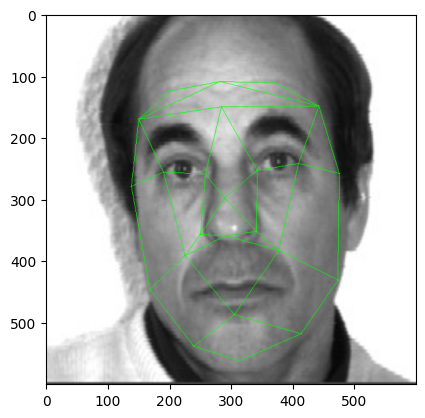

In [89]:
# path="D:\current_project\Face-Recognition-Project\\10v1\\face-recognition-phase-3.1\datasets\yale\person3\\test_image\subject12_centerlight.jpg"
# adj,features=mediapipe(path)
# dense_matrix = adj.toarray()
# has_nan = np.isnan(dense_matrix)
# print(has_nan)
# nan_indices = np.where(has_nan)
# print(nan_indices)
# for i in range(10):
#     print(adj[i])
    # print(features[i])
# adj=adj.detach().numpy()


In [90]:
# path="./datasets/yale/person3/train_images/subject12_glasses.jpg"
# adj1,features1=mediapipe(path)
# dense_matrix = adj1.toarray()
# has_nan = np.isnan(dense_matrix)
# print(has_nan)
# nan_indices = np.where(has_nan)
# print(nan_indices)
# for i in range(10):
#     print(adj1[i])
    # print(features[i])
# adj=adj.detach().numpy()


In [91]:
def matrix_similarity(matrix1, matrix2):
    # Step 1: Subtract the matrices
    diff_matrix = matrix2 - matrix1

    # Step 2: Take the absolute value of the differences
    # abs_diff_matrix = np.square(diff_matrix)
    abs_diff_matrix = np.abs(diff_matrix)

    # Step 3: Sum all the absolute differences
    total_diff = np.sum(abs_diff_matrix)

    # Step 4: Calculate the similarity score
    similarity_score = total_diff / (matrix1.size)

    # Step 5: Normalize the similarity score between 0 and 1
    max_similarity_score = np.max(np.abs(matrix1 - matrix2))  # Maximum possible similarity score
    normalized_score = 1 - (similarity_score / max_similarity_score)
 
    return normalized_score

In [92]:
# print("feature similarity = ", matrix_similarity(features1,features))
# print("weighted adjacency matrix similarity = ", matrix_similarity(adj1,adj))